<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))

In [3]:
# custom functions

from app.preprocessing import set_weekday
from app.preprocessing import set_daypart

from app.preprocessing import get_savemodel_name

from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

# Загрузка данных

In [11]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

df['datetime'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'])
df[['date', 'time']] = df['date'].str.split(' ', expand=True)[[0, 1]]
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

In [12]:
df

,datetime,date,time,open,high,low,close,volume
date,,,,,,,,
2015-01-21 01:00:00,2015-01-21 01:00:00,2015.01.21,01:00,1.15540,1.15567,1.15419,1.15449,2564
2015-01-21 02:00:00,2015-01-21 02:00:00,2015.01.21,02:00,1.15449,1.15573,1.15409,1.15505,3823
2015-01-21 03:00:00,2015-01-21 03:00:00,2015.01.21,03:00,1.15506,1.15646,1.15503,1.15613,3421
2015-01-21 04:00:00,2015-01-21 04:00:00,2015.01.21,04:00,1.15613,1.15675,1.15581,1.15662,2956
2015-01-21 05:00:00,2015-01-21 05:00:00,2015.01.21,05:00,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024-10-31 19:00:00,2024.10.31,19:00,1.08551,1.08630,1.08538,1.08583,5908
2024-10-31 20:00:00,2024-10-31 20:00:00,2024.10.31,20:00,1.08581,1.08644,1.08555,1.08620,3691
2024-10-31 21:00:00,2024-10-31 21:00:00,2024.10.31,21:00,1.08619,1.08731,1.08606,1.08705,4549


In [15]:
df.isna().mean()

datetime    0.0
date        0.0
time        0.0
open        0.0
high        0.0
low         0.0
close       0.0
volume      0.0
dtype: float64

In [17]:
df.describe(include='all')\
    .drop(['count', 'unique', 'top', 'freq'])\
    .drop(['datetime', 'date', 'time'], axis=1)

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000
std,0.051930,0.051882,0.051969,0.051929,4305.358699


# Предобработка

## День недели

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_weekday(df)
df = df[['datetime', 'date', 'weekday', 'time', 'open', 'high', 'low', 'close', 'volume']]
# df

## Часть дня

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_daypart(df)
df = df[['datetime', 'date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close', 'volume']]
# df

## Кастомные индикаторы 

In [27]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 24
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

In [29]:
df.tail(5)

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,volume_15,volume_16,volume_17,volume_18,volume_19,volume_20,volume_21,volume_22,volume_23,volume_24
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,...,2775,2342,1470,2073,1041,2306,3816,2408,3614,4064
2024-10-31 20:00:00,2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,...,2360,2775,2342,1470,2073,1041,2306,3816,2408,3614
2024-10-31 21:00:00,2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,...,1785,2360,2775,2342,1470,2073,1041,2306,3816,2408
2024-10-31 22:00:00,2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,...,2180,1785,2360,2775,2342,1470,2073,1041,2306,3816
2024-10-31 23:00:00,2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,...,1650,2180,1785,2360,2775,2342,1470,2073,1041,2306


## Финансовые индикаторы

In [32]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 24
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [34]:
df.tail(5)

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,stoch_cls_15,stoch_cls_16,stoch_cls_17,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2024-10-31 20:00:00,2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2024-10-31 21:00:00,2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2024-10-31 22:00:00,2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,...,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2024-10-31 23:00:00,2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,...,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


## Формировние Таргетной фичи

In [37]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-6)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [39]:
df.dropna(inplace=True)

## Выборки для обучения

In [42]:
df

,datetime,date,weekday,time,daypart,open,high,low,close,volume,...,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015-01-22 12:00:00,2015-01-22 12:00:00,2015.01.22,Thursday,12:00,Day,1.16230,1.16385,1.16062,1.16263,10840,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.14127,0,1
2015-01-22 13:00:00,2015-01-22 13:00:00,2015.01.22,Thursday,13:00,Day,1.16263,1.16440,1.16173,1.16261,9483,...,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.13823,0,1
2015-01-22 14:00:00,2015-01-22 14:00:00,2015.01.22,Thursday,14:00,Day,1.16260,1.16513,1.15874,1.16302,17753,...,-1.0,-1.0,0.0,0.0,0.0,1.0,1.0,1.13760,0,1
2015-01-22 15:00:00,2015-01-22 15:00:00,2015.01.22,Thursday,15:00,Day,1.16303,1.16373,1.15110,1.15625,41429,...,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,1.13782,0,1
2015-01-22 16:00:00,2015-01-22 16:00:00,2015.01.22,Thursday,16:00,Day,1.15623,1.15654,1.14520,1.14623,51568,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.13600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 13:00:00,2024-10-31 13:00:00,2024.10.31,Thursday,13:00,Day,1.08663,1.08754,1.08646,1.08671,4153,...,1.0,1.0,1.0,0.0,-1.0,-1.0,0.0,1.08583,0,1
2024-10-31 14:00:00,2024-10-31 14:00:00,2024.10.31,Thursday,14:00,Day,1.08670,1.08699,1.08592,1.08687,3455,...,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,1.08620,0,1
2024-10-31 15:00:00,2024-10-31 15:00:00,2024.10.31,Thursday,15:00,Day,1.08689,1.08866,1.08640,1.08796,8350,...,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,1.08705,0,1


In [44]:
train, valid, test = pdf.split.inherit_train_valid_test(df)

          count  pct
train     36399  0.6
valid     12133  0.2
test      12133  0.2
                    
Amount    60665  1.0
InitData  60665     


In [46]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count       pct
train     18199  0.499986
test      18200  0.500014
                         
Amount    36399       1.0
InitData  36399          


# CatBoost Обучение

In [49]:
train.columns

Index(['datetime', 'date', 'weekday', 'time', 'daypart', 'open', 'high', 'low',
       'close', 'volume',
       ...
       'stoch_cls_18', 'stoch_cls_19', 'stoch_cls_20', 'stoch_cls_21',
       'stoch_cls_22', 'stoch_cls_23', 'stoch_cls_24', 'y_close', 'y_true',
       'y_true_down'],
      dtype='object', length=239)

In [51]:
list_base_time = ['weekday', 'daypart']

list_base = ['open', 'high', 'low', 'close', 'volume']

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch']
list_L1_cst = ['shd', 'trend', 'volume_']

list_cat_feat = ['cls', 'weekday', 'daypart']

list_y = ['y_close']

In [53]:
XL1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

print(f'XL1 len: {len(XL1)}')
print(f'XL1:\n\t{XL1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1 len: 233
XL1:
	['weekday', 'daypart', 'open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'trend_cls_11', 'trend_cls_12', 'trend_cls_13', 'trend_cls_14', 'trend_cls_1

In [55]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

def asint(x): return x.astype(int) if x.dtype == float else x

train[cat_features]  = train[cat_features].apply(asint, axis=0)
train1[cat_features] = train[cat_features].apply(asint, axis=0)
train2[cat_features] = train[cat_features].apply(asint, axis=0)

valid[cat_features]  = valid[cat_features].apply(asint, axis=0)
test[cat_features]   = test[cat_features].apply(asint, axis=0)

## Level 1 - Regression

### Regression 1

In [59]:
param_R1L1 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [61]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [63]:
start = time.time()
model_R1L1.fit(train1[XL1], train1[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0262991	test: 0.0619950	best: 0.0619950 (0)	total: 130ms	remaining: 21m 43s
200:	learn: 0.0101535	test: 0.0329629	best: 0.0329629 (200)	total: 24.1s	remaining: 19m 35s
400:	learn: 0.0044636	test: 0.0201652	best: 0.0201652 (400)	total: 47.8s	remaining: 19m 3s
600:	learn: 0.0026445	test: 0.0149611	best: 0.0149611 (600)	total: 1m 11s	remaining: 18m 42s
800:	learn: 0.0021608	test: 0.0129380	best: 0.0129380 (800)	total: 1m 36s	remaining: 18m 22s
1000:	learn: 0.0020388	test: 0.0121585	best: 0.0121585 (1000)	total: 2m	remaining: 18m
1200:	learn: 0.0019998	test: 0.0118255	best: 0.0118255 (1200)	total: 2m 24s	remaining: 17m 38s
1400:	learn: 0.0019788	test: 0.0116886	best: 0.0116886 (1400)	total: 2m 48s	remaining: 17m 17s
1600:	learn: 0.0019639	test: 0.0116256	best: 0.0116254 (1599)	total: 3m 13s	remaining: 16m 53s
1800:	learn: 0.0019520	test: 0.0116053	best: 0.0116053 (1800)	total: 3m 37s	remaining: 16m 28s
2000:	learn: 0.0019415	test: 0.0116000	best: 0.0115995 (1958)	total: 4m 1s	r

In [64]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_3.cbm


In [67]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[XL1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[XL1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[XL1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

valid.loc[:, 'predict_R1L1']     = model_R1L1.predict(valid[XL1])
valid.loc[:, 'predict_cls_R1L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R1L1']) * 1

In [68]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.001801
MAPE   0.001671
SMAPE  0.001670
RMSE   0.002699
RMSLE  0.001303
CONFMAT  (2333, 3575, 2477, 3748)              
ROC_AUC  0.50
PRECREC  0.51


### Regression 2

In [71]:
param_R2L1 = param_R1L1

In [73]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [75]:
start = time.time()
model_R2L1.fit(train2[XL1], train2[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0297694	test: 0.0601960	best: 0.0601960 (0)	total: 136ms	remaining: 22m 38s
200:	learn: 0.0112103	test: 0.0342308	best: 0.0342308 (200)	total: 23.8s	remaining: 19m 21s
400:	learn: 0.0044882	test: 0.0243172	best: 0.0243172 (400)	total: 48.4s	remaining: 19m 19s
600:	learn: 0.0023009	test: 0.0204536	best: 0.0204536 (600)	total: 1m 12s	remaining: 18m 46s
800:	learn: 0.0017052	test: 0.0188793	best: 0.0188793 (800)	total: 1m 35s	remaining: 18m 18s
1000:	learn: 0.0015605	test: 0.0182446	best: 0.0182446 (1000)	total: 1m 59s	remaining: 17m 58s
1200:	learn: 0.0015131	test: 0.0179581	best: 0.0179581 (1200)	total: 2m 27s	remaining: 18m 3s
1400:	learn: 0.0014904	test: 0.0178472	best: 0.0178471 (1399)	total: 2m 54s	remaining: 17m 48s
1600:	learn: 0.0014749	test: 0.0178123	best: 0.0178122 (1599)	total: 3m 20s	remaining: 17m 30s
1800:	learn: 0.0014628	test: 0.0177987	best: 0.0177986 (1793)	total: 3m 46s	remaining: 17m 9s
2000:	learn: 0.0014537	test: 0.0177951	best: 0.0177949 (1930)	total: 

In [76]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_3.cbm


In [77]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,XL1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,XL1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,XL1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

valid.loc[:, 'predict_R2L1']     = model_R2L1.predict(valid.loc[:,XL1])
valid.loc[:, 'predict_cls_R2L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R2L1']) * 1

In [78]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,XL1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.006038
MAPE   0.005680
SMAPE  0.005632
RMSE   0.010418
RMSLE  0.005045
CONFMAT  (1409, 4499, 1272, 4953)              
ROC_AUC  0.52
PRECREC  0.52


## Level 2 - Classification

### Classification 1 - UP

In [83]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
XL2 = XL1.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y_up: \n\t{y_up}')
print(f'y_down: \n\t{y_down}')

XL2 len: 237
XL2: 
	['weekday', 'daypart', 'open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'trend_cls_11', 'trend_cls_12', 'trend_cls_13', 'trend_cls_14', 'trend_cls_

In [85]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [87]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [89]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(valid[XL2], valid[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930604	test: 0.6931658	best: 0.6931658 (0)	total: 170ms	remaining: 28m 21s
bestTest = 0.693165801
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:18


In [90]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_3.cbm


In [91]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (2338, 3570, 2284, 3941)              
ROC_AUC  0.51
PRECREC  0.52


In [92]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 1 - DOWN

In [97]:
paramC2L2 = paramC1L2

In [99]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [101]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(valid[XL2], valid[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930569	test: 0.6931565	best: 0.6931565 (0)	total: 181ms	remaining: 30m 6s
bestTest = 0.6931565449
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:18


In [102]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_3.cbm


In [103]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (3950, 2309, 3535, 2339)              
ROC_AUC  0.51
PRECREC  0.49


In [104]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [106]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(5)

,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
date,,,,,,,,
2024-10-31 13:00:00,1.08671,1.08583,0,1,1,0,0.500229,0.499730
2024-10-31 14:00:00,1.08687,1.08620,0,1,1,0,0.500266,0.499768
2024-10-31 15:00:00,1.08796,1.08705,0,1,1,0,0.500522,0.499465
2024-10-31 16:00:00,1.08595,1.08774,1,0,1,0,0.500522,0.499465
2024-10-31 17:00:00,1.08648,1.08814,1,0,1,0,0.500522,0.499465


CONFMAT  (43, 5, 41, 7)              
ROC_AUC  0.52
PRECREC  0.51


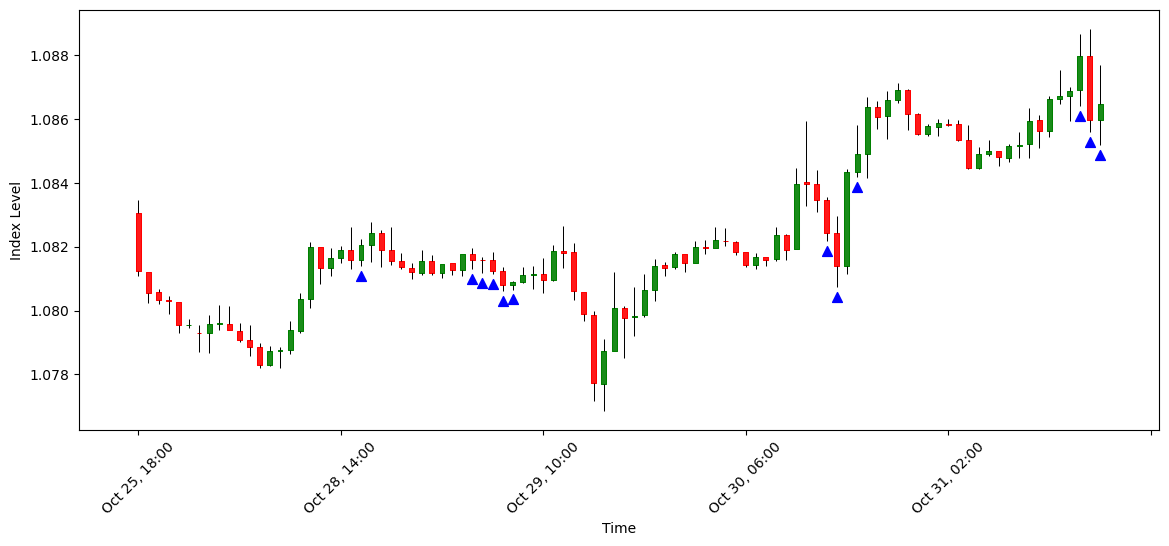

In [107]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

data = test.tail(12*8)
data.index = pd.to_datetime(data.index)

threshold = 0
threshold = 0.0005

data['ind_up'] = ((data['pred_y_up'] - data['pred_y_down']) > threshold).astype(float)
data.loc[data['ind_up'] != 1, 'ind_up'] = float("NaN")
data.loc[data['ind_up'] == 1, 'ind_up'] = data['low'] - 0.0003

data['ind_down'] = ((data['pred_y_down'] - data['pred_y_up']) > threshold).astype(float)
data.loc[data['ind_down'] != 1, 'ind_down'] = float("NaN")
data.loc[data['ind_down'] == 1, 'ind_down'] = data['high'] + 0.0003

res = data[['y_true', 'ind_up']]

res.loc[res['ind_up'] > 0, 'ind_pred'] = 1
res.loc[res['ind_pred'] != 1.0, 'ind_pred'] = 0
res['ind_pred'] = res['ind_pred'].astype(int)

pdf.metrics.metrics_class(res.loc[:,'y_true'], res.loc[:,'ind_pred'])

add_plot = [
    mpf.make_addplot(data['ind_up'],
                     type='scatter', color='blue',
                     marker='^', markersize=50,
                     panel=0,
                     ),

    # mpf.make_addplot(data['ind_down'],
    #                  type='scatter', color='blue',
    #                  marker='v', markersize=50,
    #                  panel=0
    #                  )
]

mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='black',
    volume='in',
    ohlc='i',
)

s = mpf.make_mpf_style(
    marketcolors=mc,
)

mpf.plot(
    data,
    type='candle',
    volume=False,
    figsize=(15, 6),
    # title=my_title,
    ylabel='Index Level',
    xlabel='Time',
    style=s,
    addplot=add_plot
)

In [118]:
res.tail(15)

,y_true,ind_up,ind_pred
date,,,
2024-10-31 03:00:00,0,NaN,0
2024-10-31 04:00:00,1,NaN,0
2024-10-31 05:00:00,1,NaN,0
2024-10-31 06:00:00,1,NaN,0
2024-10-31 07:00:00,1,NaN,0
2024-10-31 08:00:00,1,NaN,0
2024-10-31 09:00:00,1,NaN,0
2024-10-31 10:00:00,1,NaN,0
2024-10-31 11:00:00,1,NaN,0
